## Imports

In [1]:
import pandas as pd
import category_encoders
import numpy as np
from matplotlib import pyplot as plt
from scipy import interp

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import TransformerMixin
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from pipeline.custom_transformers import NAEncoder, ColumnDropper

In [2]:
X_train = pd.read_csv('data/X_train.csv', na_values=['N/A or Unknown', 'unknown'])
y_train = pd.read_csv('data/y_train.csv', names=['injury'])

In [3]:
def visualize_roc_auc(X_train, y_train, classifier):
    plt.figure(figsize=(18,10))

    cv = StratifiedKFold(n_splits=6)

    X, y = X_train, y_train.values.ravel()
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

## Baseline

In [4]:
clf = make_pipeline(category_encoders.OneHotEncoder(), LogisticRegression())

cvx = cross_validate(
    clf, 
    X_train, y_train.values.ravel(), 
    scoring='roc_auc', n_jobs=-1, cv=15, return_train_score=False
)
cvx['test_score'].mean(), cvx['test_score'].std()

(0.6135396142851122, 0.02175195531730229)

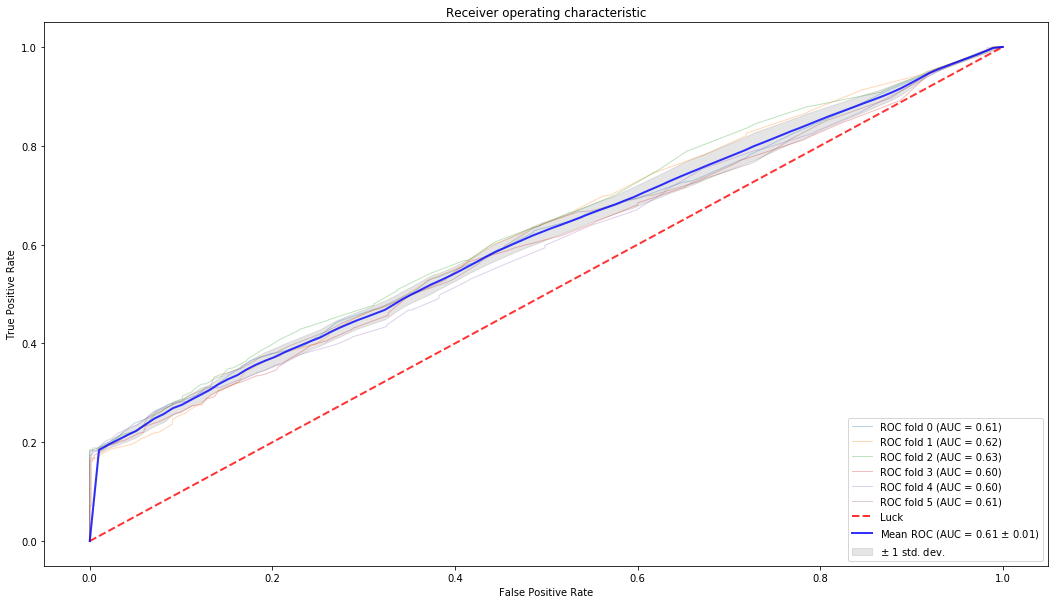

In [5]:
visualize_roc_auc(X_train, y_train, clf)

## Model selection

In [6]:
names = ["Nearest Neighbors", 
         "Decision Tree", 
         "Random Forest", 
         "Neural Net", 
         "AdaBoost",
         "Naive Bayes",
         "XGBoost",
         "LightGBM",
         "Logistic Regression"]
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    XGBClassifier(),
    LGBMClassifier(),
    LogisticRegression()
]

for name, clf in zip(names, classifiers):
    pipeline = make_pipeline(
        NAEncoder(['other_person_location']),
        NAEncoder(['other_factor_1', 'other_factor_2', 'other_factor_3']),
        ColumnDropper('age_in_years'),
        category_encoders.OneHotEncoder(impute_missing=False),
        clf
    )

    cvx = cross_validate(
        pipeline, 
        X_train, y_train.values.ravel(), 
        scoring='roc_auc', n_jobs=-1, cv=15, return_train_score=False, 
    )
    print (name, cvx['test_score'].mean(), cvx['test_score'].std())

Nearest Neighbors 0.5824872973205729 0.02764310849556343
Decision Tree 0.6085504156962913 0.013164203372976847
Random Forest 0.6078243383451253 0.011864850254015789
Neural Net 0.6034172313756204 0.013553373774203181
AdaBoost 0.6031300261125538 0.017115456680725196
Naive Bayes 0.6052936261879763 0.013991410050303427
XGBoost 0.6102930656890361 0.013019572037251978
LightGBM 0.6081408691875966 0.012830953267385732
Logistic Regression 0.6052910156524373 0.017396995877530397


## Tuned model

In [7]:
pipeline = make_pipeline(
    ColumnDropper('age_in_years'),
    NAEncoder(['other_person_location']),
    NAEncoder(['other_factor_1', 'other_factor_2', 'other_factor_3']),
    category_encoders.OneHotEncoder(), 
    XGBClassifier(base_score=np.mean(y_train.values), booster='dart',
       colsample_bylevel=1, colsample_bytree=0.55, gamma=1,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
       nthread=1, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, silent=True,
       subsample=1
    )
)

cvx = cross_validate(
        pipeline, 
        X_train, y_train.values.ravel(), 
        scoring='roc_auc', n_jobs=-1, cv=15, return_train_score=False, 
)
print ("XGBoost", cvx['test_score'].mean(), cvx['test_score'].std())

XGBoost 0.6111012639332903 0.012417192105302857


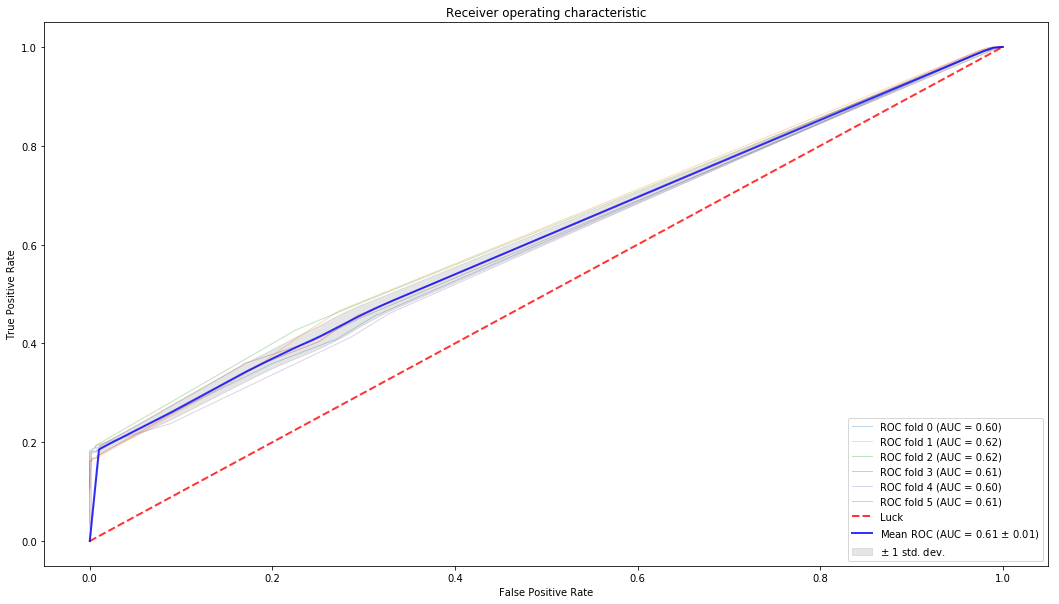

In [8]:
visualize_roc_auc(X_train, y_train, pipeline)